In [1]:
import os
import sys
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.dont_write_bytecode = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (1) 資料準備

In [2]:
def gen_data(n_size):
    return np.sin(np.linspace(0, 10*np.pi, n_size))

def cut_win(dataset, winsize):
    x, y = list(), list()
    for t in range(winsize, len(dataset)):
        x += [dataset[t - winsize:t]]
        y += [[dataset[t]]]
    x, y = np.array(x), np.array(y)
    print("[Data set] x: {}, y: {}".format(x.shape, y.shape))
    return x, y

def to_TimeSerie_torch(arr):
    res = torch.tensor(arr).unsqueeze(2).to(torch.float32)
    print("[torch tensor] {}".format(res.shape))
    return res
x, y = cut_win(gen_data(1000), 20)
x, y = to_TimeSerie_torch(x), to_TimeSerie_torch(y)

[Data set] x: (980, 20), y: (980, 1)
[torch tensor] torch.Size([980, 20, 1])
[torch tensor] torch.Size([980, 1, 1])


In [3]:
class MyDataset(Dataset):
    def __init__(self, data, targ):
        """
        初始化資料
        :param data: 特徵數據，例如 numpy array 或 list
        :param labels: 對應的預測數據
        """
        self.data = data
        self.targ = targ

    def __len__(self):
        """返回資料集的樣本數量"""
        return len(self.data)

    def __getitem__(self, idx):
        """
        根據索引返回數據與標籤
        :param idx: 索引
        :return: 單個數據與其標籤
        """
        x = self.data[idx]
        y = self.targ[idx]
        return x, y
# 使用方法
# dataset = MyDataset(data, labels)
# dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
x, y = x.to(device), y.to(device)
dataloader = DataLoader(MyDataset(x, y), batch_size=2, shuffle=True)

# (2) 模型建構

In [10]:
def reconstruct_series(Model, Input, n_size):
    res = Input.reshape(-1, ).tolist()
    for i in range(n_size):
        out, _, _ = Model(Input)
        res += [float(out.reshape(-1, ))]
        Input = torch.tensor([res[-Input.shape[1]:]]).to(torch.float32).unsqueeze(2).to(device)
    return res

In [5]:
from Bayesian_Attention_Autoregressive import Bayesian_Attn_AR, criterion
        
history = list()
model = Bayesian_Attn_AR(n_seq = 20, n_hid = 16, n_dim = 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# (3) 訓練

In [6]:
epoch = 0
while True:
    try:
        epoch += 1
        loss_val = 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
            y_hat, mu, logvar = model(x_batch)
            loss = criterion(y_hat, y_batch, mu, logvar)
            loss_val += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        history += [loss_val]
        print(f"Epoch {epoch}, Loss {loss_val}", end = "\r")
    except:
        break

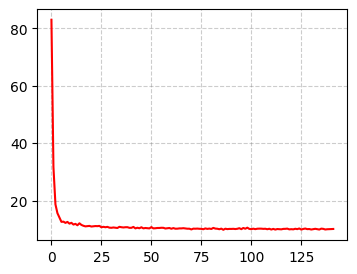

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (4, 3))
ax.plot(history, color = "red")
ax.grid(color = "gray", linestyle = "--", alpha = .4)
plt.show()

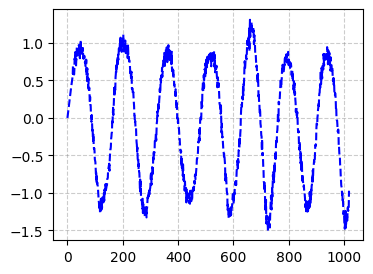

In [11]:
with torch.no_grad():
    recon_data = reconstruct_series(model, x[0:1], 1000)
plt.figure(figsize = (4, 3))
plt.plot(recon_data, color = "blue", linestyle = "--")
plt.grid(color = "gray", linestyle = "--", alpha = .4)